In [1]:
import sys

sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns


# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


In [3]:
settings.log_dir

PosixPath('../tune')

We have 419 batches in the dataset

In [4]:
len(traindataset) // 32


419

In [5]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [6]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-07-01 13:41:51.727 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [7]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]


2

# Question 1
Figure out, for every class, what accuracy you should expect if the model would guess blind on the train set

In [8]:
# TODO ~ about 4 lines of code
label_dict = {
    "humor": 0,
    "reuters": 0,
    "wiki": 0,
    "proverbs": 0
}

for row in traindataset.dataset:
    label_dict[row[1]] += 1

print(label_dict)

for k in label_dict:
    label_dict[k] =  label_dict[k] / len(traindataset.dataset) * 100

print(label_dict)


{'humor': 4213, 'reuters': 4186, 'wiki': 4181, 'proverbs': 831}
{'humor': 31.414510476474533, 'reuters': 31.21318320781448, 'wiki': 31.175900380284844, 'proverbs': 6.196405935426143}


Reflect on what you see. What does this mean? What implications does this have? Why is that good/bad?
Are there things down the line that could cause a problem?

### ANSWER
Due to the disbalance in the classes (4th to be precise) the model will probably tend to fit on the first three classes as these are easier to guess. Mostly the minority class will cause problems if we need to predict these. 

# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [9]:
# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    def cast_label(self, label: str) -> int:
        if label == "humor":
            return 0
        elif label == "reuters":
            return 1
        elif label == "wiki":
            return 2
        elif label == "proverbs":
            return 3

To test the preprocessor:

In [10]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
x1, y1=preprocessor([(x, y)])


# Set up the model
We can re-use the BaseDatastreamer

In [11]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [12]:
x, y = next(trainstreamer)
x.shape, y

(torch.Size([32, 39]),
 tensor([0, 0, 1, 3, 1, 1, 2, 1, 2, 0, 2, 0, 1, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0, 1,
         0, 1, 0, 2, 1, 1, 2, 1]))

## Question 3 : Metrics, loss
Select proper metrics and a loss function.

Bonus: implement an additional metric function that is relevant for this case.

In [13]:
from src.models import metrics
from sklearn.metrics import f1_score
import torch
# TODO ~ 2 lines of code

metric = metrics.F1Score()
loss_fn = torch.nn.CrossEntropyLoss()

Tensor = torch.Tensor

class WeightedF1Score(metrics.Metric):
    def __repr__(self) -> str:
        return "WeightedF1Score"

    def __call__(self, y: Tensor, yhat: Tensor) -> Tensor:
        yhat = yhat.argmax(dim=1)
        score = f1_score(y, yhat, average="weighted")
        return torch.tensor(score)



In [14]:
type(metric)

src.models.metrics.F1Score

## Question 4 : Basemodel
Create a base model. It does not need to be naive; you could re-use the
NLP models we used for the IMDB.

I suggest to start with a hidden size of about 128.
Use a config dictionary, or a gin file, both are fine.

Bonus points if you create a Trax model in src.models, and even more if you add a trax training loop.

In [15]:
log_dir = settings.log_dir
# TODO between 2 and 8 lines of code, depending on your setup
# Assuming you load your model in one line of code from src.models.rnn
from src.models import rnn

config= {
    "vocab": len(v),
    "hidden_size": 128,
    "num_layers": 3,
    "dropout": 0.1,
    "output_size": 4,
}

model = rnn.NLPmodel(config)


Set up the trainloop.

- Give the lenght of the traindataset, how many batches of 32 can you get out of it?
- If you take a short amount of train_steps (eg 25) for every epoch, how many epochs do you need to cover the complete dataset?
- What amount of epochs do you need to run the loop with trainsteps=25 to cover the complete traindataset once? 
- answer the questions above, and pick a reasonable epoch lenght

Start with a default learning_rate of 1e-3 and an Adam optimizer.

In [ ]:
from src.training import train_model

model = train_model.trainloop(
    epochs=50,
    model=model,
    metrics=[metric],
    optimizer=torch.optim.Adam,
    learning_rate=1e-3,
    loss_fn=loss_fn,
    train_dataloader=trainstreamer,
    test_dataloader=teststreamer,
    log_dir=log_dir,
    train_steps=25,
    eval_steps=25,
)


Save an image from the training in tensorboard in the `figures` folder.
Explain what you are seeing.

In [16]:
import math
print(
    f'''
    1.  {len(traindataset)} datapoints divided by batches of size 32 equals {len(traindataset) / 32} batches before the dataset could be fully seen.
        Rounded up this would become 420
    2.  Depending on the way we look at the question it can either be {(len(traindataset)  + len(testdataset)) / (25 * 32)} or 21 epochs. 
        When we consider the train and test sets to be both run through the trainstep() function.
        If we consider the trainset in the evalbatches() and the trainset in the trainstep() functions
        then we take the max between those two for a total of {max(len(testdataset) / (25*32),
     len(traindataset) / (25*32))} (17 when rounded) epochs.
    3.  {len(traindataset) / (25*32)} or 17 rounded up.
    4.  25 epochs should be reasonable maybe 50 to be sure we have seen more combinations within the dataset. 
        If we want to go big and come close to the total amount of permutations the traindataset contains
        we can go up to the humongous number below given basic combinatoric math 
        (https://statisticsbyjim.com/probability/permutations-probabilities/): 
        {math.factorial(len(traindataset)) // math.factorial((len(traindataset) - (25*32)))}
    5.  in the image "tune/20220621-1931"  (could not save the image to the figure folder, sorry!)
        we can see only marginally smaal improvements after epoch 25.
        Even worse we see signals of overfitting where the test dataset loss is not improving (only wobbling)
        the train loss is decreasing comparatively a lot (the two are even diverging starting from epoch 45).
        This indicates that the model is learning the patterns in the trainset and not generalizing on the data.
    '''
)


    1.  13411 datapoints divided by batches of size 32 equals 419.09375 batches before the dataset could be fully seen.
        Rounded up this would become 420
    2.  Depending on the way we look at the question it can either be 20.955 or 21 epochs. 
        When we consider the train and test sets to be both run through the trainstep() function.
        If we consider the trainset in the evalbatches() and the trainset in the trainstep() functions
        then we take the max between those two for a total of 16.76375 (17 when rounded) epochs.
    3.  16.76375 or 17 rounded up.
    4.  25 epochs should be reasonable maybe 50 to be sure we have seen more combinations within the dataset. 
        If we want to go big and come close to the total amount of permutations the traindataset contains
        we can go up to the humongous number below given basic combinatoric math 
        (https://statisticsbyjim.com/probability/permutations-probabilities/): 
        25535954275326972078962366

In [ ]:
!tensorboard --logdir "/home/mladmin/code/eind_opdracht/examen-22/tune"

# 5 Evaluate the basemodel
Create a confusion matrix with the code below

[Text(0.5, 15.0, 'Predicted'), Text(33.0, 0.5, 'Target')]

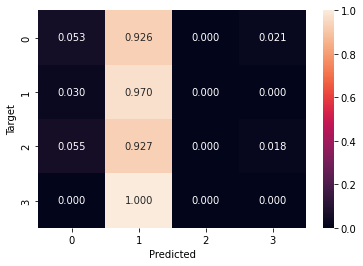

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for _ in range(10):
    X, y = next(teststreamer)
    yhat = model(X)
    yhat = yhat.argmax(dim=1)
    y_pred.append(yhat.tolist())
    y_true.append(y.tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")


Save this in the figures folder.
Interpret this. 

- What is going on?
- What is a good metric here?
- how is your answer to Q1 relevant here?
- Is there something you could do to fix/improve things, after you see these results?

1. The confusionmatrix shows the accuracy (as per the documentation of scikitlearn). This confusion matrix shows the a multiclass classification instead of the standard binary variant. Within each of the rows in this matrix the total should be 1 (or 100%). 
2. I would prefere the F1 metric or even better the F1 weighted metric to have a better feeling how the model performs overal. But, because we know right now that the dataset is imbalanced the accuracy is not a bad score to check our performance and get an idea of the model and if it is performing better than a dumb model.
3. because of the data imbalance we know that acc should be higher than ~30 percent for the majority classes and higher than ~5 percent for the minority class. This in turn tells us that the current model is doing a better job than pure gambling
4. We could try under or over sampling (I would say under sampling because I do not have the knoweledge regarding over sampling in NLP). Other ways to combat this is maybe using the weighted F1 metric (giving the minority class as much importance as the majority classes) or a weighted loss function. But this wholy depends on the goal of the project. If errors in the minority class are of no problem then tackling this problem give rise to different solutions than when the minority class is the most important.

# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

## 6.1 imports

In [18]:
import trax
from trax import layers as tl
from trax.layers import combinators as cb
from trax.shapes import signature
from trax.supervised import training
from trax.supervised.lr_schedules import warmup_and_rsqrt_decay
from trax.layers.assert_shape import assert_shape
import jax.numpy as jnp
from jax import jit
import numpy as np

from pathlib import Path

2022-07-01 13:41:59.601481: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


## 6.2 Pipeline

In [19]:
preprocessor = StylePreprocessor(max=50, vocab=v, clean=tokenizer.clean)
trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset,
    batchsize=32,
    preprocessor=preprocessor
).stream()

teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset,
    batchsize=32,
    preprocessor=preprocessor
).stream()

def Cast():
    '''
    NOTE MAEL:
    This function casts an input tensor to an numpy array.
    During this process the numpy array will be padded to a fixed lenght
    Because the stylepreprocessor uses the torch function pad_sequence()
    max length within the current batch, I had to work around this.
    changing the tokenizer could be an option but seeing other notebooks might use this
    I opted to change this function instead. 

    The cause to implement this was a trax error where every batch yielded different sized tensors as input X
    '''
    def f(generator, max_len=50):
        for x, y in generator:
            new_x= []
            _x = x.numpy()
            for i, emb in enumerate(_x):
                np_array_to_pad = emb
                new_x.append(np.pad(np_array_to_pad, (0, max_len - len(np_array_to_pad))))
            yield np.array(new_x), y.numpy()
        return new_x
    return lambda g: f(g)

data_pipeline = trax.data.Serial(Cast())
trainpipe = data_pipeline(trainstreamer)
testpipe = data_pipeline(teststreamer)
X, y= next(trainpipe)
X.shape, y.shape

((32, 50), (32,))

## 6.3 model

### 6.3.1 model 1 basic model

In [ ]:
base_model = cb.Serial(
    tl.Dense(128),
    tl.Relu(),
    tl.Dense(4)
)

lr = warmup_and_rsqrt_decay(100, 0.01)

# base_model._clear_init_cache()

base_model.init_weights_and_state(X)

### 6.3.2 model 2 with larger first dense layer

In [ ]:
base_model2 = cb.Serial(
    tl.Dense(256),
    tl.Relu(),
    tl.Dense(4)
)

lr = warmup_and_rsqrt_decay(100, 0.01)

base_model.init_weights_and_state(X)
print(X.shape)

### 6.3.3 model 3 a RNN network

In [126]:
def AvgLast():
    return tl.Fn("AvgLast", lambda x: x.mean(axis=-1), n_out=1)

@assert_shape("bs->bl")
def rnn(vocab_size, feature_size, n_out):
    rnn_model = cb.Serial(
        tl.Embedding(vocab_size=vocab_size, d_feature=feature_size),
        tl.GRU(n_units=feature_size),
        tl.BatchNorm(),
        AvgLast(),
        tl.Dense(n_out)
    )

    return rnn_model

rnn_model = rnn(len(v), 128, 4)   
lr = warmup_and_rsqrt_decay(100, 0.01)

rnn_model.init_weights_and_state(signature(X))


/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-Z0MsbPIA-py3.9/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:1939: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in zeros is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "zeros")


### 6.3.4 Basic Attention

In [134]:
attention_model = cb.Serial(
    tl.Embedding(vocab_size= len(v), d_feature= 128),
    cb.Branch(
        tl.SelfAttention(4),
        None
    ),
    tl.Add(),
    tl.LayerNorm(),
    cb.Branch(
        tl.Dense(128),
        None
    ),
    tl.Relu(),
    tl.Add(),
    tl.LayerNorm(),
    tl.Dense(4),
    AvgLast(),
    
    # tl.SplitIntoHeads(8),
    # tl.Attention(128, 8)
    # tl.DotProductAttention(),   
)
lr = warmup_and_rsqrt_decay(100, 0.01)


In [135]:
attention_model.init_weights_and_state(signature(X))
attention_model(X).shape

(32, 50)

In [136]:
y = attention_model(X)

In [137]:
y.shape

(32, 50)

### 6.3.5 New Attention

In [187]:
attention_model2 = cb.Serial(
        cb.Branch(
            cb.Serial(
                tl.Embedding(vocab_size= len(v), d_feature= 128),
                tl.LayerNorm()
            ),
            tl.PaddingMask()
            ),
    tl.Attention(128, n_heads= 4),
    tl.Select([0], n_in=2),
    tl.Dense(4),    
)
lr = warmup_and_rsqrt_decay(100, 0.01)
attention_model2.init_weights_and_state(signature(X))
y = attention_model2(X)
y.shape

(32, 50, 4)

## 6.4 training

In [140]:
OUTPUT_PATH = Path("../tune_trax/attention_model2")

train_task = training.TrainTask(
    labeled_data=trainpipe,
    loss_layer=tl.CategoryCrossEntropy(),
    optimizer=trax.optimizers.Adam(),
    lr_schedule=lr
)

eval_task = training.EvalTask(
    labeled_data=testpipe,
    metrics=[tl.CategoryAccuracy(), tl.WeightedFScore(), tl.MacroAveragedFScore(), tl.CategoryCrossEntropy()],
    n_eval_batches=10
)

loop = training.Loop(
    attention_model2,
    train_task,
    eval_tasks=[eval_task],
    output_dir=OUTPUT_PATH,
)

In [141]:
loop.run(1000)


Step      1: Total number of trainable weights: 2620036
Step      1: Ran 1 train steps in 6.53 secs
Step      1: train CategoryCrossEntropy |  3.90695858
Step      1: eval      CategoryAccuracy |  0.07187500
Step      1: eval        WeightedFScore |  0.10536353
Step      1: eval   MacroAveragedFScore |  0.00728775
Step      1: eval  CategoryCrossEntropy |  3.82001815

Step    100: Ran 99 train steps in 5.56 secs
Step    100: train CategoryCrossEntropy |  2.45681620
Step    100: eval      CategoryAccuracy |  0.26250000
Step    100: eval        WeightedFScore |  0.31884521
Step    100: eval   MacroAveragedFScore |  0.02180175
Step    100: eval  CategoryCrossEntropy |  2.39533935

Step    200: Ran 100 train steps in 5.74 secs
Step    200: train CategoryCrossEntropy |  2.21110559
Step    200: eval      CategoryAccuracy |  0.30937500
Step    200: eval        WeightedFScore |  0.39211036
Step    200: eval   MacroAveragedFScore |  0.02720054
Step    200: eval  CategoryCrossEntropy |  2.24503

In [142]:
!tensorboard --logdir "/home/mladmin/code/eind_opdracht/examen-22/tune_trax"

2022-06-28 15:47:40.551516: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 15:47:42.984674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-28 15:47:42.984715: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.9.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C


## 6.5 Discussion

Due to trax beign the most unfamilair to me I tried implementing 3 trax models. Due to the way the StyleSettings class was set up it was not possible to train multiple models. All config and setting files would be saved to the ../tune folder. This made it impossible to run the train loop on two seperate models. To remedy this I decided to opt for changing the log_dir to a variable that could more closly be controlled. the ../tune/model_1 and ../tune/model_2 folders proofs this is working as intendended.

The first model was only for testing a basic architecture using Trax. It only has 3 layers: 
1. a Dense(128) layer
2. a RELU activation layer
3. a Dense(4) layer

The second model only enlarged the first Dense layer from 128 to 256. This allowed me to test the checkpoint saving and loading used by Trax's loop.run(). Looking at the eval tensorboard files for both models We can at least see that a simple model using a smaller dense layer performs somewhat better than the larger model.

The third was done using a RNN with a GRU cell. The goal for me was to try and lay the foundations for an attention network. Getting the RNN to run was the first step. And, looking at the Eval statistics we get a large improvement over the first two models. This should ofcourse come to no suprise as RNN's are better suited for NLP tasks, given their memory of the input. Looking at the logs more training would not produce any better results, as the curve seems to be evening out the model might have learned al it can. We could tinker with the layers, batch sizes or learning rates but, to challenge myself, I will try to implement an attention layer next. 

Sadly implementing the attention layer did not seem to have a great effect. I tried to implement the right side of the attentionmodel in the standard transformernet by Vaswani et al. 2017 that was presented to us during lesson 5_attention.
